# 计算机视觉课程作业
以下任务均在当前image-classifier.ipynb中执行，需要完整执行所有代码，并保存输出结果。完成任务后提交image-classifier.ipynb文件。
### 任务一：提升模型预测准确率
以下代码已经实现了基本的CIFAR-10图像分类。   
在不使用其他预训练模型下（即只能在CIFAR-10数据上从头训练模型），请通过数据增强、模型结构优化、更改优化策略（优化器，epoch，损失函数等）等方式提升模型预测准确率。   
<font color=red>注意：成绩会通过“Step 5: Evaluate model accuracy”的输出结果Average Acc进行评分，请勿更改step 5的代码，且需要完整执行所有代码。</font>

### 任务二：T-SNE
使用pytorch中的hook提取测试集“testloader”在模型中间层的特征表示，并使用T-SNE方法进行可视化。   
<font color=red>注意：可视化结果应当作为"Step 6: T-SNE Visualization"的输出结果。</font>

# 任务一：提升模型预测准确率

## Step 1: Download a dataset and preview images

A model is only as good as its dataset.

Training tools need lots of high-quality data to build accurate models. We'll use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) of 60,000 photos to build our image classifier. Get started by downloading the dataset with `torchvision` and previewing a handful of images from it.

Files already downloaded and verified
Files already downloaded and verified


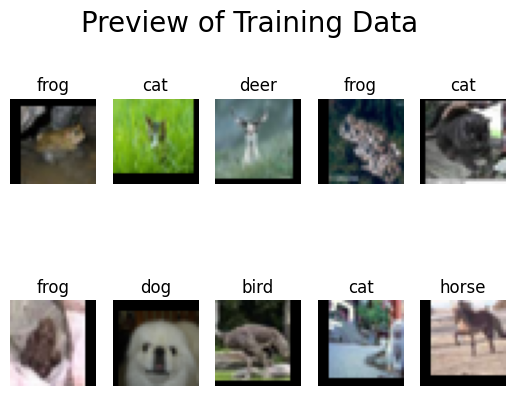

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

# Download the CIFAR-10 dataset to ./data
batch_size=10
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Data Augmentation and Preprocessing
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
print("Downloading training data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

total_size = len(trainset)
train_size = int(0.9 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation
# Split the dataset into training and validation sets
trainset, valset = random_split(trainset, [train_size, val_size])

# Create data loaders for training and validation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Downloading testing data...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)



# Our model will recognize these kinds of objects
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Grab images from our training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    plt.title(classes[labels[i]])

plt.suptitle('Preview of Training Data', size=20)
plt.show()

# Step 2: Configure the neural network

Now that we have our dataset, we need to set up a neural network for PyTorch. Our neural network will transform an image into a description.

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define a convolutional neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)

EPOCHS = 50

# Learning Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=0.00001)

print("Your network is ready for training!")

Your network is ready for training!


# Step 3: Train the network and save model

PyTorch trains our network by adjusting its parameters and evaluating its performance against our labelled dataset.

In [3]:
from tqdm import tqdm

print("Training...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    net.train()
    
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch + 1} of {EPOCHS}", leave=True, ncols=80)):
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    net.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch + 1} - Loss: {running_loss / len(trainloader):.4f}, Validation Accuracy: {100 * correct / total:.2f}%")
    scheduler.step()

# Save our trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Training...


Epoch 1 of 50: 100%|███████████████████████| 4500/4500 [00:26<00:00, 170.66it/s]


Epoch 1 - Loss: 1.8697, Validation Accuracy: 38.86%


Epoch 2 of 50: 100%|███████████████████████| 4500/4500 [00:26<00:00, 169.22it/s]


Epoch 2 - Loss: 1.4846, Validation Accuracy: 49.54%


Epoch 3 of 50: 100%|███████████████████████| 4500/4500 [00:26<00:00, 172.79it/s]


Epoch 3 - Loss: 1.2889, Validation Accuracy: 53.14%


Epoch 4 of 50: 100%|███████████████████████| 4500/4500 [00:26<00:00, 171.53it/s]


Epoch 4 - Loss: 1.1586, Validation Accuracy: 61.76%


Epoch 5 of 50: 100%|███████████████████████| 4500/4500 [00:26<00:00, 169.93it/s]


Epoch 5 - Loss: 1.0688, Validation Accuracy: 63.50%


Epoch 6 of 50: 100%|███████████████████████| 4500/4500 [00:26<00:00, 167.71it/s]


Epoch 6 - Loss: 1.0011, Validation Accuracy: 66.34%


Epoch 7 of 50: 100%|███████████████████████| 4500/4500 [00:26<00:00, 168.62it/s]


Epoch 7 - Loss: 0.9414, Validation Accuracy: 67.86%


Epoch 8 of 50: 100%|███████████████████████| 4500/4500 [00:25<00:00, 174.88it/s]


Epoch 8 - Loss: 0.8887, Validation Accuracy: 67.96%


Epoch 9 of 50: 100%|███████████████████████| 4500/4500 [00:25<00:00, 174.52it/s]


Epoch 9 - Loss: 0.8482, Validation Accuracy: 68.72%


Epoch 10 of 50: 100%|██████████████████████| 4500/4500 [00:26<00:00, 167.21it/s]


Epoch 10 - Loss: 0.8090, Validation Accuracy: 70.30%


Epoch 11 of 50: 100%|██████████████████████| 4500/4500 [00:25<00:00, 174.59it/s]


Epoch 11 - Loss: 0.7852, Validation Accuracy: 70.56%


Epoch 12 of 50: 100%|██████████████████████| 4500/4500 [00:27<00:00, 165.61it/s]


Epoch 12 - Loss: 0.7519, Validation Accuracy: 72.64%


Epoch 13 of 50: 100%|██████████████████████| 4500/4500 [00:26<00:00, 167.24it/s]


Epoch 13 - Loss: 0.7232, Validation Accuracy: 72.60%


Epoch 14 of 50: 100%|██████████████████████| 4500/4500 [00:26<00:00, 172.02it/s]


Epoch 14 - Loss: 0.7036, Validation Accuracy: 73.10%


Epoch 15 of 50: 100%|██████████████████████| 4500/4500 [00:25<00:00, 179.04it/s]


Epoch 15 - Loss: 0.6754, Validation Accuracy: 74.38%


Epoch 16 of 50: 100%|██████████████████████| 4500/4500 [00:25<00:00, 176.26it/s]


Epoch 16 - Loss: 0.6553, Validation Accuracy: 74.58%


Epoch 17 of 50: 100%|██████████████████████| 4500/4500 [00:24<00:00, 183.56it/s]


Epoch 17 - Loss: 0.6405, Validation Accuracy: 72.56%


Epoch 18 of 50: 100%|██████████████████████| 4500/4500 [00:26<00:00, 169.85it/s]


Epoch 18 - Loss: 0.6188, Validation Accuracy: 74.80%


Epoch 19 of 50: 100%|██████████████████████| 4500/4500 [00:25<00:00, 177.05it/s]


Epoch 19 - Loss: 0.6030, Validation Accuracy: 74.86%


Epoch 20 of 50: 100%|██████████████████████| 4500/4500 [00:25<00:00, 178.19it/s]


Epoch 20 - Loss: 0.5900, Validation Accuracy: 75.22%


Epoch 21 of 50: 100%|██████████████████████| 4500/4500 [00:25<00:00, 177.57it/s]


Epoch 21 - Loss: 0.5694, Validation Accuracy: 76.10%


Epoch 22 of 50: 100%|██████████████████████| 4500/4500 [00:25<00:00, 177.21it/s]


Epoch 22 - Loss: 0.5544, Validation Accuracy: 76.44%


Epoch 23 of 50: 100%|██████████████████████| 4500/4500 [00:26<00:00, 172.69it/s]


Epoch 23 - Loss: 0.5463, Validation Accuracy: 76.14%


Epoch 24 of 50: 100%|██████████████████████| 4500/4500 [00:25<00:00, 175.17it/s]


Epoch 24 - Loss: 0.5237, Validation Accuracy: 76.98%


Epoch 25 of 50: 100%|██████████████████████| 4500/4500 [00:26<00:00, 169.28it/s]


Epoch 25 - Loss: 0.5139, Validation Accuracy: 76.80%


Epoch 26 of 50: 100%|██████████████████████| 4500/4500 [00:24<00:00, 180.40it/s]


Epoch 26 - Loss: 0.4975, Validation Accuracy: 77.84%


Epoch 27 of 50: 100%|██████████████████████| 4500/4500 [00:25<00:00, 176.66it/s]


Epoch 27 - Loss: 0.4870, Validation Accuracy: 77.46%


Epoch 28 of 50: 100%|██████████████████████| 4500/4500 [00:24<00:00, 181.90it/s]


Epoch 28 - Loss: 0.4720, Validation Accuracy: 77.06%


Epoch 29 of 50: 100%|██████████████████████| 4500/4500 [00:26<00:00, 171.38it/s]


Epoch 29 - Loss: 0.4583, Validation Accuracy: 78.22%


Epoch 30 of 50: 100%|██████████████████████| 4500/4500 [00:25<00:00, 176.69it/s]


Epoch 30 - Loss: 0.4485, Validation Accuracy: 78.10%


Epoch 31 of 50: 100%|██████████████████████| 4500/4500 [00:26<00:00, 168.55it/s]


Epoch 31 - Loss: 0.4381, Validation Accuracy: 77.92%


Epoch 32 of 50: 100%|██████████████████████| 4500/4500 [00:27<00:00, 160.73it/s]


Epoch 32 - Loss: 0.4258, Validation Accuracy: 78.32%


Epoch 33 of 50: 100%|██████████████████████| 4500/4500 [00:25<00:00, 175.40it/s]


Epoch 33 - Loss: 0.4188, Validation Accuracy: 78.74%


Epoch 34 of 50: 100%|██████████████████████| 4500/4500 [00:27<00:00, 164.17it/s]


Epoch 34 - Loss: 0.4069, Validation Accuracy: 78.70%


Epoch 35 of 50: 100%|██████████████████████| 4500/4500 [00:26<00:00, 171.74it/s]


Epoch 35 - Loss: 0.3963, Validation Accuracy: 78.62%


Epoch 36 of 50: 100%|██████████████████████| 4500/4500 [00:25<00:00, 174.98it/s]


Epoch 36 - Loss: 0.3842, Validation Accuracy: 78.34%


Epoch 37 of 50: 100%|██████████████████████| 4500/4500 [00:26<00:00, 169.82it/s]


Epoch 37 - Loss: 0.3791, Validation Accuracy: 79.42%


Epoch 38 of 50: 100%|██████████████████████| 4500/4500 [00:26<00:00, 172.63it/s]


Epoch 38 - Loss: 0.3709, Validation Accuracy: 78.78%


Epoch 39 of 50: 100%|██████████████████████| 4500/4500 [00:26<00:00, 170.37it/s]


Epoch 39 - Loss: 0.3653, Validation Accuracy: 79.46%


Epoch 40 of 50: 100%|██████████████████████| 4500/4500 [00:25<00:00, 177.63it/s]


Epoch 40 - Loss: 0.3573, Validation Accuracy: 79.76%


Epoch 41 of 50: 100%|██████████████████████| 4500/4500 [00:25<00:00, 179.60it/s]


Epoch 41 - Loss: 0.3516, Validation Accuracy: 79.80%


Epoch 42 of 50: 100%|██████████████████████| 4500/4500 [00:25<00:00, 176.49it/s]


Epoch 42 - Loss: 0.3427, Validation Accuracy: 80.06%


Epoch 43 of 50: 100%|██████████████████████| 4500/4500 [00:25<00:00, 176.85it/s]


Epoch 43 - Loss: 0.3365, Validation Accuracy: 79.58%


Epoch 44 of 50: 100%|██████████████████████| 4500/4500 [00:25<00:00, 175.98it/s]


Epoch 44 - Loss: 0.3332, Validation Accuracy: 80.54%


Epoch 45 of 50: 100%|██████████████████████| 4500/4500 [00:26<00:00, 169.24it/s]


Epoch 45 - Loss: 0.3301, Validation Accuracy: 80.14%


Epoch 46 of 50: 100%|██████████████████████| 4500/4500 [00:26<00:00, 171.46it/s]


Epoch 46 - Loss: 0.3257, Validation Accuracy: 79.34%


Epoch 47 of 50: 100%|██████████████████████| 4500/4500 [00:26<00:00, 167.46it/s]


Epoch 47 - Loss: 0.3266, Validation Accuracy: 80.48%


Epoch 48 of 50: 100%|██████████████████████| 4500/4500 [00:27<00:00, 163.47it/s]


Epoch 48 - Loss: 0.3211, Validation Accuracy: 79.76%


Epoch 49 of 50: 100%|██████████████████████| 4500/4500 [00:26<00:00, 172.28it/s]


Epoch 49 - Loss: 0.3255, Validation Accuracy: 80.16%


Epoch 50 of 50: 100%|██████████████████████| 4500/4500 [00:26<00:00, 167.62it/s]


Epoch 50 - Loss: 0.3154, Validation Accuracy: 80.06%


# Step 4: Test the trained model

Let's test our model!

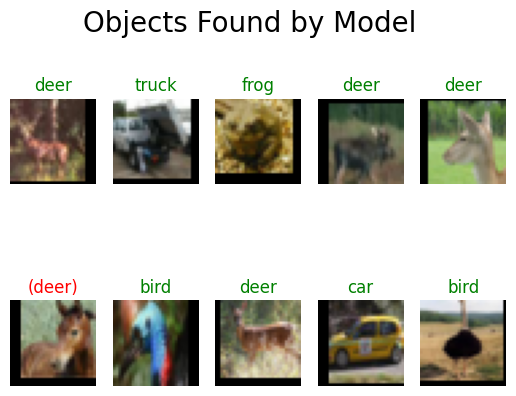

In [4]:
# Pick random photos from training set
if dataiter == None:
    dataiter = iter(testloader)
images, labels = next(dataiter)

# Load our model
net = Net()
net.load_state_dict(torch.load(PATH))

# Analyze images
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Show results
for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Objects Found by Model', size=20)
plt.show()

# Step 5: Evaluate model accuracy

Let's conclude by evaluating our model's overall performance.

In [5]:
# Measure accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy statistics
average_accuray = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    average_accuray.append(accuracy)
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
print ('Average Acc:', np.mean(average_accuray))

Accuracy for class: plane is 86.7 %
Accuracy for class: car   is 90.5 %
Accuracy for class: bird  is 76.9 %
Accuracy for class: cat   is 66.4 %
Accuracy for class: deer  is 82.1 %
Accuracy for class: dog   is 72.6 %
Accuracy for class: frog  is 87.4 %
Accuracy for class: horse is 85.7 %
Accuracy for class: ship  is 89.3 %
Accuracy for class: truck is 89.4 %
Average Acc: 82.69999999999999


# 任务二：T-SNE

# Step 6: T-SNE Visualization

Visualize high-dimensional data in a low-dimensional space using T-SNE.

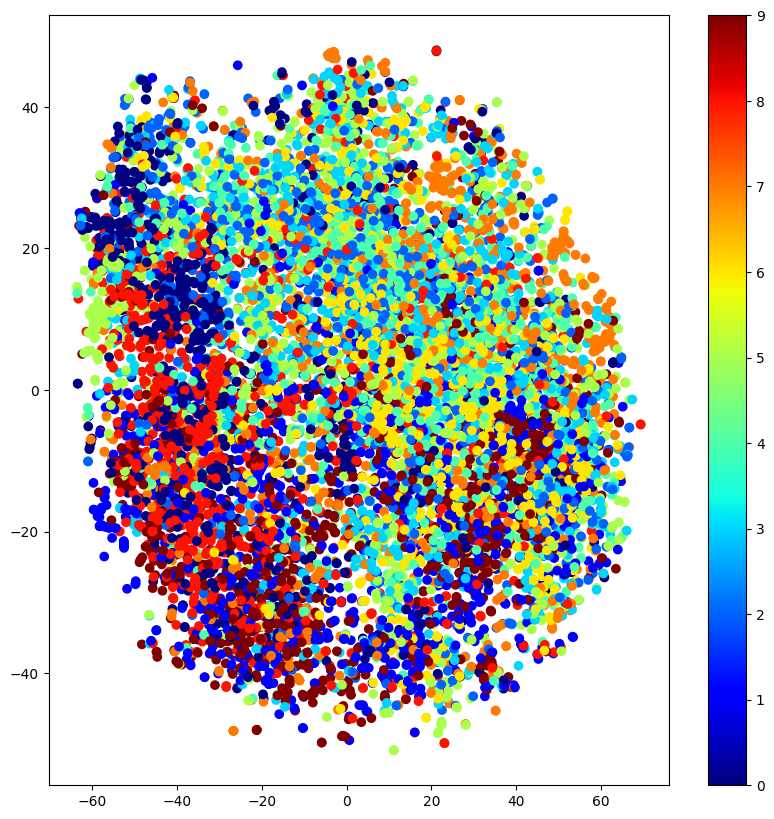

In [4]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

model = Net()
model.eval()

features = []

def hook_fn(module, input, output):
    features.append(output)


layer_index = 2
model.fc1.register_forward_hook(hook_fn)

# Define a function to extract features from the test set
def extract_features():
    feature_list = []

    with torch.no_grad():
        for data in testloader:
            inputs, _ = data
            _ = model(inputs)

    for feature in features:
        feature_list.append(feature)

    return feature_list

# Extract features from the test set
features = extract_features()

# Concatenate and reshape the features
features = torch.cat(features).view(len(testset), -1).numpy()

# Perform T-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
reduced_features = tsne.fit_transform(features)

# Plot the T-SNE visualization
plt.figure(figsize=(10, 10))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=testset.targets, cmap='jet')
plt.colorbar()
plt.show()

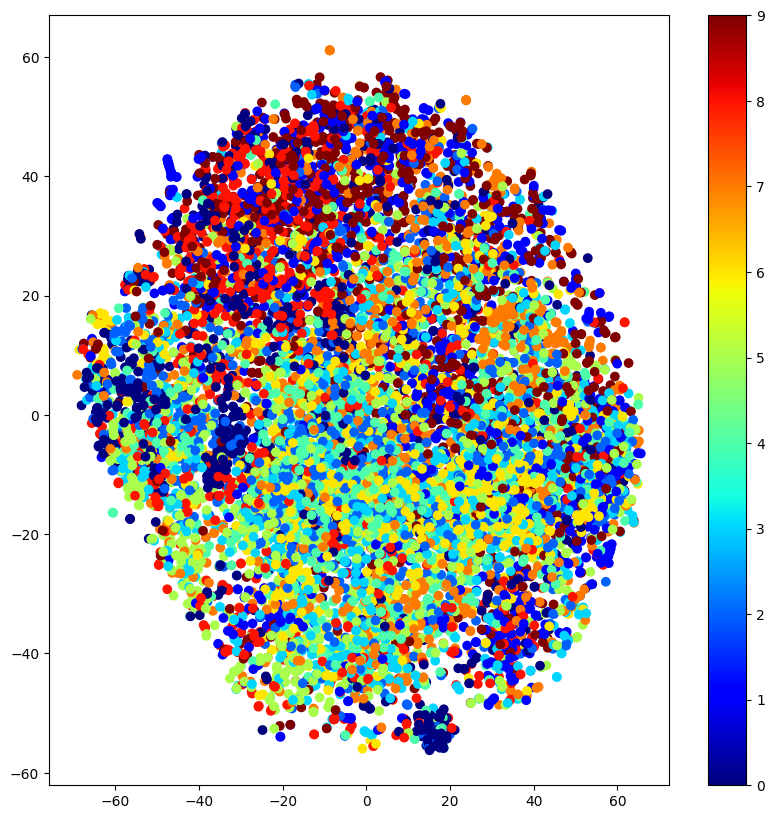

In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

model = Net()
model.eval()

features = []

def hook_fn(module, input, output):
    features.append(output)


layer_index = 2
model.fc2.register_forward_hook(hook_fn)

# Define a function to extract features from the test set
def extract_features():
    feature_list = []

    with torch.no_grad():
        for data in testloader:
            inputs, _ = data
            _ = model(inputs)

    for feature in features:
        feature_list.append(feature)

    return feature_list

# Extract features from the test set
features = extract_features()

# Concatenate and reshape the features
features = torch.cat(features).view(len(testset), -1).numpy()

# Perform T-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
reduced_features = tsne.fit_transform(features)

# Plot the T-SNE visualization
plt.figure(figsize=(10, 10))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=testset.targets, cmap='jet')
plt.colorbar()
plt.show()

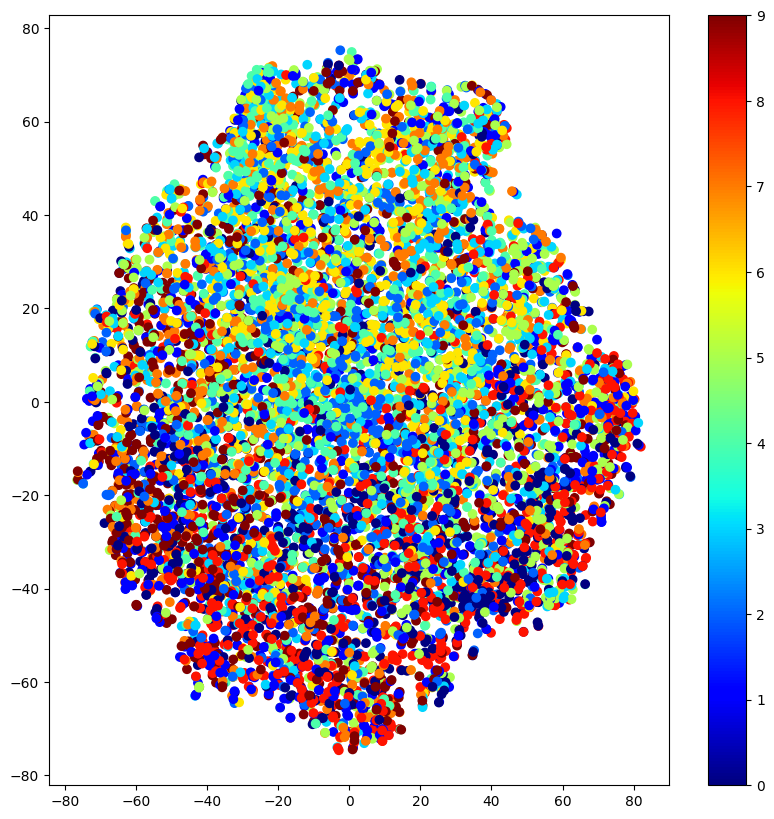

In [6]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

model = Net()
model.eval()

features = []

def hook_fn(module, input, output):
    features.append(output)


layer_index = 2
model.fc3.register_forward_hook(hook_fn)

# Define a function to extract features from the test set
def extract_features():
    feature_list = []

    with torch.no_grad():
        for data in testloader:
            inputs, _ = data
            _ = model(inputs)

    for feature in features:
        feature_list.append(feature)

    return feature_list

# Extract features from the test set
features = extract_features()

# Concatenate and reshape the features
features = torch.cat(features).view(len(testset), -1).numpy()

# Perform T-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
reduced_features = tsne.fit_transform(features)

# Plot the T-SNE visualization
plt.figure(figsize=(10, 10))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=testset.targets, cmap='jet')
plt.colorbar()
plt.show()